In [1]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): w


Параметры пучков и спектры

In [2]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)

In [3]:
m = 30
target = R(Material(m), 0.01)

brems = [target.brem(beams_energy) for beams_energy in beams_energyes]
brems_e = [brem * en for brem in brems]

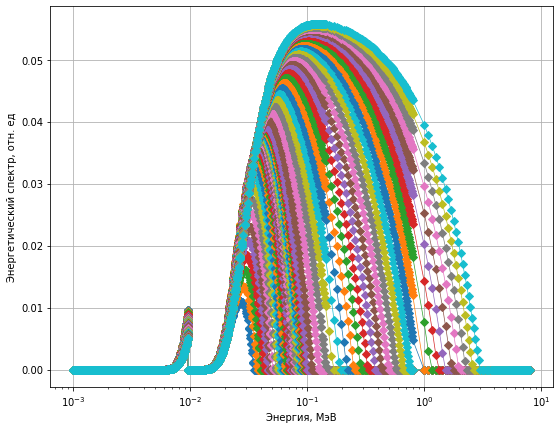

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))

for br in brems_e:
    ax.plot(en, br, ls='-', marker='D', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

Номер первого канала и К-скачки

In [5]:
n = 11

In [6]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [7]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Уровни пропускания в К-крае

In [8]:
linspace3 = np.linspace(0.001, 0.9, 101)
for i, val in enumerate(linspace3):
    linspace3[i] = round(val, 5)
    
edge_max_values = []
edge_max_values.extend(linspace3)

Спектральные характеристики чувствительности каналов

In [9]:
edge_thiknesses = [[Material(i).lt(j) for i in range(n, 101)] for j in edge_max_values]

In [10]:
edge_regions = [[R(Material(i+n), edge_thiknesses[j][i]) for i in range(0, len(edge_thiknesses[j]))] for j in range(len(edge_thiknesses))]
resp_edges = [[val.f() for val in edge_regions[j]] for j in range(len(edge_regions))]

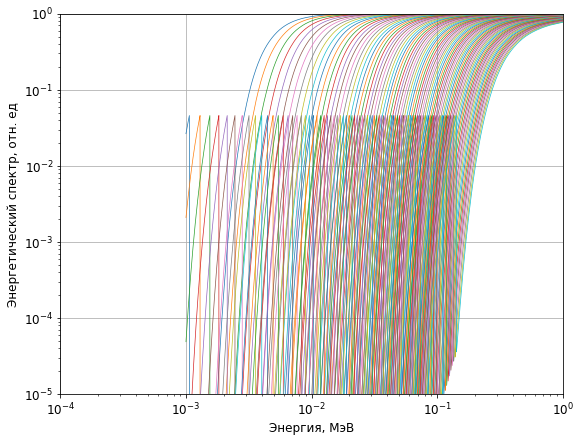

In [11]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_edges[5]:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

Матрицы задач

In [12]:
from garipov_deconvolution import get_coeff_simpson

In [13]:
Matrixs = []

start_time = time.time()

for i in range(len(resp_edges)):
    print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
    matrix = []
    
    for response in resp_edges[i]:
        matrix.append(get_coeff_simpson(response, en, EDGE)[0])
    
    Matrixs.append(matrix)

(0), время: 0.0 секунд
(1), время: 3.05028 секунд
(2), время: 6.11355 секунд
(3), время: 9.23228 секунд
(4), время: 12.46273 секунд
(5), время: 15.51236 секунд
(6), время: 18.57635 секунд
(7), время: 21.72295 секунд
(8), время: 24.89793 секунд
(9), время: 28.00738 секунд
(10), время: 30.98567 секунд
(11), время: 34.14296 секунд
(12), время: 37.77679 секунд
(13), время: 41.31649 секунд
(14), время: 44.45379 секунд
(15), время: 47.68467 секунд
(16), время: 50.79475 секунд
(17), время: 53.95417 секунд
(18), время: 57.11767 секунд
(19), время: 60.23523 секунд
(20), время: 63.39423 секунд
(21), время: 66.47653 секунд
(22), время: 69.52071 секунд
(23), время: 72.49334 секунд
(24), время: 75.42709 секунд
(25), время: 78.35464 секунд
(26), время: 81.38342 секунд
(27), время: 84.34821 секунд
(28), время: 87.37511 секунд
(29), время: 90.36319 секунд
(30), время: 93.46356 секунд
(31), время: 96.57352 секунд
(32), время: 99.59065 секунд
(33), время: 102.68373 секунд
(34), время: 105.6601 секунд
(3

Сигналы измерительных каналов

In [14]:
new_en = get_coeff_simpson(resp_edges[0][0], en, EDGE)[1]

In [15]:
def signals_from_one_spectrum(spectrum):
    
    start_time = time.time()
    signals_simpson = []
    
    # для каждой матрицы
    for i, matrix in enumerate(Matrixs):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        
        # сигналы для каждой задачи
        signals = []
        
        # для каждой строки в матрице
        for row in matrix:
            # значение одного сигнала
            signal = sum(row * np.interp(new_en, en, spectrum))
            signals.append(signal)
            
        signals_simpson.append(signals)
        
    return signals_simpson

Сигналы для каждого спектра

In [16]:
spectrums_signals = []

for spectrum in brems_e:
    spectrums_signals.append(signals_from_one_spectrum(spectrum))

(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.07811 секунд
(3), время: 0.12937 секунд
(4), время: 0.16228 секунд
(5), время: 0.1952 секунд
(6), время: 0.2291 секунд
(7), время: 0.26102 секунд
(8), время: 0.29493 секунд
(9), время: 0.32884 секунд
(10), время: 0.36175 секунд
(11), время: 0.39666 секунд
(12), время: 0.42957 секунд
(13), время: 0.46348 секунд
(14), время: 0.49639 секунд
(15), время: 0.52731 секунд
(16), время: 0.56022 секунд
(17), время: 0.5842 секунд
(18), время: 0.61544 секунд
(19), время: 0.64669 секунд
(20), время: 0.69355 секунд
(21), время: 0.72479 секунд
(22), время: 0.75603 секунд
(23), время: 0.77166 секунд
(24), время: 0.8029 секунд
(25), время: 0.83414 секунд
(26), время: 0.86538 секунд
(27), время: 0.89663 секунд
(28), время: 0.94349 секунд
(29), время: 0.97473 секунд
(30), время: 1.00598 секунд
(31), время: 1.03722 секунд
(32), время: 1.06846 секунд
(33), время: 1.09971 секунд
(34), время: 1.13095 секунд
(35), время: 1.17332 секунд
(36), врем

(98), время: 3.43163 секунд
(99), время: 3.4785 секунд
(100), время: 3.52536 секунд
(0), время: 0.0 секунд
(1), время: 0.03049 секунд
(2), время: 0.06146 секунд
(3), время: 0.0927 секунд
(4), время: 0.12395 секунд
(5), время: 0.15519 секунд
(6), время: 0.18643 секунд
(7), время: 0.22975 секунд
(8), время: 0.25867 секунд
(9), время: 0.27632 секунд
(10), время: 0.32319 секунд
(11), время: 0.35443 секунд
(12), время: 0.38567 секунд
(13), время: 0.41691 секунд
(14), время: 0.46791 секунд
(15), время: 0.49487 секунд
(16), время: 0.52612 секунд
(17), время: 0.57298 секунд
(18), время: 0.60422 секунд
(19), время: 0.63547 секунд
(20), время: 0.67579 секунд
(21), время: 0.70771 секунд
(22), время: 0.72637 секунд
(23), время: 0.77324 секунд
(24), время: 0.80448 секунд
(25), время: 0.83572 секунд
(26), время: 0.88258 секунд
(27), время: 0.92818 секунд
(28), время: 0.94418 секунд
(29), время: 0.99105 секунд
(30), время: 1.02229 секунд
(31), время: 1.05353 секунд
(32), время: 1.08478 секунд
(33), в

(95), время: 3.14742 секунд
(96), время: 3.17866 секунд
(97), время: 3.20991 секунд
(98), время: 3.26917 секунд
(99), время: 3.28682 секунд
(100), время: 3.31806 секунд
(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.06249 секунд
(3), время: 0.10429 секунд
(4), время: 0.13521 секунд
(5), время: 0.15519 секунд
(6), время: 0.18644 секунд
(7), время: 0.21768 секунд
(8), время: 0.26454 секунд
(9), время: 0.29578 секунд
(10), время: 0.34199 секунд
(11), время: 0.37094 секунд
(12), время: 0.40219 секунд
(13), время: 0.43343 секунд
(14), время: 0.48029 секунд
(15), время: 0.51154 секунд
(16), время: 0.54278 секунд
(17), время: 0.58961 секунд
(18), время: 0.62053 секунд
(19), время: 0.65282 секунд
(20), время: 0.66844 секунд
(21), время: 0.69968 секунд
(22), время: 0.73092 секунд
(23), время: 0.76217 секунд
(24), время: 0.79341 секунд
(25), время: 0.82962 секунд
(26), время: 0.85458 секунд
(27), время: 0.88583 секунд
(28), время: 0.91707 секунд
(29), время: 0.94831 секунд
(30),

(94), время: 3.0724 секунд
(95), время: 3.10365 секунд
(96), время: 3.15051 секунд
(97), время: 3.18176 секунд
(98), время: 3.213 секунд
(99), время: 3.24424 секунд
(100), время: 3.28211 секунд
(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.07811 секунд
(3), время: 0.10935 секунд
(4), время: 0.1406 секунд
(5), время: 0.17184 секунд
(6), время: 0.20599 секунд
(7), время: 0.24826 секунд
(8), время: 0.2795 секунд
(9), время: 0.31074 секунд
(10), время: 0.34198 секунд
(11), время: 0.37323 секунд
(12), время: 0.41024 секунд
(13), время: 0.43321 секунд
(14), время: 0.46446 секунд
(15), время: 0.4957 секунд
(16), время: 0.52695 секунд
(17), время: 0.55819 секунд
(18), время: 0.58943 секунд
(19), время: 0.62524 секунд
(20), время: 0.65021 секунд
(21), время: 0.68146 секунд
(22), время: 0.7127 секунд
(23), время: 0.74394 секунд
(24), время: 0.75957 секунд
(25), время: 0.79081 секунд
(26), время: 0.8318 секунд
(27), время: 0.86272 секунд
(28), время: 0.88369 секунд
(29), время: 

(94), время: 3.28369 секунд
(95), время: 3.31493 секунд
(96), время: 3.34617 секунд
(97), время: 3.37742 секунд
(98), время: 3.40866 секунд
(99), время: 3.4399 секунд
(100), время: 3.48095 секунд
(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.06249 секунд
(3), время: 0.09373 секунд
(4), время: 0.12497 секунд
(5), время: 0.15622 секунд
(6), время: 0.199 секунд
(7), время: 0.21799 секунд
(8), время: 0.26486 секунд
(9), время: 0.2961 секунд
(10), время: 0.32734 секунд
(11), время: 0.35858 секунд
(12), время: 0.39798 секунд
(13), время: 0.4299 секунд
(14), время: 0.45055 секунд
(15), время: 0.49741 секунд
(16), время: 0.52865 секунд
(17), время: 0.57552 секунд
(18), время: 0.61607 секунд
(19), время: 0.64698 секунд
(20), время: 0.66797 секунд
(21), время: 0.69921 секунд
(22), время: 0.73046 секунд
(23), время: 0.7617 секунд
(24), время: 0.80856 секунд
(25), время: 0.85572 секунд
(26), время: 0.89162 секунд
(27), время: 0.91626 секунд
(28), время: 0.9475 секунд
(29), время:

(90), время: 3.14774 секунд
(91), время: 3.1654 секунд
(92), время: 3.19664 секунд
(93), время: 3.22788 секунд
(94), время: 3.27475 секунд
(95), время: 3.30599 секунд
(96), время: 3.32161 секунд
(97), время: 3.37338 секунд
(98), время: 3.39901 секунд
(99), время: 3.44587 секунд
(100), время: 3.49274 секунд
(0), время: 0.0 секунд
(1), время: 0.05409 секунд
(2), время: 0.09169 секунд
(3), время: 0.12293 секунд
(4), время: 0.13855 секунд
(5), время: 0.1698 секунд
(6), время: 0.20104 секунд
(7), время: 0.24382 секунд
(8), время: 0.27474 секунд
(9), время: 0.29273 секунд
(10), время: 0.3396 секунд
(11), время: 0.35522 секунд
(12), время: 0.38646 секунд
(13), время: 0.41771 секунд
(14), время: 0.44895 секунд
(15), время: 0.48978 секунд
(16), время: 0.5197 секунд
(17), время: 0.54134 секунд
(18), время: 0.5882 секунд
(19), время: 0.61945 секунд
(20), время: 0.63507 секунд
(21), время: 0.66631 секунд
(22), время: 0.69755 секунд
(23), время: 0.7391 секунд
(24), время: 0.75909 секунд
(25), время

(84), время: 2.84916 секунд
(85), время: 2.87515 секунд
(86), время: 2.92201 секунд
(87), время: 2.96888 секунд
(88), время: 3.00012 секунд
(89), время: 3.03136 секунд
(90), время: 3.07462 секунд
(91), время: 3.10723 секунд
(92), время: 3.1541 секунд
(93), время: 3.21658 секунд
(94), время: 3.24783 секунд
(95), время: 3.28769 секунд
(96), время: 3.31861 секунд
(97), время: 3.34025 секунд
(98), время: 3.38711 секунд
(99), время: 3.41835 секунд
(100), время: 3.4496 секунд
(0), время: 0.0 секунд
(1), время: 0.04075 секунд
(2), время: 0.06073 секунд
(3), время: 0.09197 секунд
(4), время: 0.12322 секунд
(5), время: 0.15446 секунд
(6), время: 0.1857 секунд
(7), время: 0.21695 секунд
(8), время: 0.26208 секунд
(9), время: 0.29403 секунд
(10), время: 0.30965 секунд
(11), время: 0.34089 секунд
(12), время: 0.37214 секунд
(13), время: 0.40338 секунд
(14), время: 0.43462 секунд
(15), время: 0.48135 секунд
(16), время: 0.51327 секунд
(17), время: 0.5429 секунд
(18), время: 0.57415 секунд
(19), вре

(80), время: 2.88323 секунд
(81), время: 2.91447 секунд
(82), время: 2.93009 секунд
(83), время: 2.96133 секунд
(84), время: 2.99258 секунд
(85), время: 3.02382 секунд
(86), время: 3.06327 секунд
(87), время: 3.08525 секунд
(88), время: 3.11649 секунд
(89), время: 3.14773 секунд
(90), время: 3.17898 секунд
(91), время: 3.21022 секунд
(92), время: 3.24146 секунд
(93), время: 3.28195 секунд
(94), время: 3.31386 секунд
(95), время: 3.34914 секунд
(96), время: 3.38038 секунд
(97), время: 3.41162 секунд
(98), время: 3.44287 секунд
(99), время: 3.47411 секунд
(100), время: 3.50774 секунд
(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.06249 секунд
(3), время: 0.09373 секунд
(4), время: 0.12497 секунд
(5), время: 0.16054 секунд
(6), время: 0.19345 секунд
(7), время: 0.21644 секунд
(8), время: 0.24768 секунд
(9), время: 0.29454 секунд
(10), время: 0.32579 секунд
(11), время: 0.35703 секунд
(12), время: 0.41047 секунд
(13), время: 0.43344 секунд
(14), время: 0.46469 секунд
(15),

(73), время: 2.43508 секунд
(74), время: 2.48194 секунд
(75), время: 2.53907 секунд
(76), время: 2.56999 секунд
(77), время: 2.58997 секунд
(78), время: 2.62122 секунд
(79), время: 2.65246 секунд
(80), время: 2.69933 секунд
(81), время: 2.73057 секунд
(82), время: 2.78387 секунд
(83), время: 2.82247 секунд
(84), время: 2.85371 секунд
(85), время: 2.88495 секунд
(86), время: 2.91619 секунд
(87), время: 2.96106 секунд
(88), время: 2.99198 секунд
(89), время: 3.0226 секунд
(90), время: 3.05385 секунд
(91), время: 3.08509 секунд
(92), время: 3.11633 секунд
(93), время: 3.14757 секунд
(94), время: 3.17882 секунд
(95), время: 3.2138 секунд
(96), время: 3.23844 секунд
(97), время: 3.28531 секунд
(98), время: 3.31655 секунд
(99), время: 3.36341 секунд
(100), время: 3.41293 секунд
(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.06249 секунд
(3), время: 0.10935 секунд
(4), время: 0.14059 секунд
(5), время: 0.18635 секунд
(6), время: 0.2163 секунд
(7), время: 0.24755 секунд
(8), в

(67), время: 2.19231 секунд
(68), время: 2.22356 секунд
(69), время: 2.27982 секунд
(70), время: 2.29981 секунд
(71), время: 2.33106 секунд
(72), время: 2.3623 секунд
(73), время: 2.39354 секунд
(74), время: 2.42478 секунд
(75), время: 2.47234 секунд
(76), время: 2.5003 секунд
(77), время: 2.53154 секунд
(78), время: 2.56279 секунд
(79), время: 2.59403 секунд
(80), время: 2.62527 секунд
(81), время: 2.67213 секунд
(82), время: 2.7124 секунд
(83), время: 2.73337 секунд
(84), время: 2.76462 секунд
(85), время: 2.81148 секунд
(86), время: 2.84273 секунд
(87), время: 2.87397 секунд
(88), время: 2.92508 секунд
(89), время: 2.955 секунд
(90), время: 2.98262 секунд
(91), время: 3.01387 секунд
(92), время: 3.04511 секунд
(93), время: 3.07635 секунд
(94), время: 3.10759 секунд
(95), время: 3.15079 секунд
(96), время: 3.18171 секунд
(97), время: 3.19937 секунд
(98), время: 3.23061 секунд
(99), время: 3.26185 секунд
(100), время: 3.29309 секунд
(0), время: 0.0 секунд
(1), время: 0.04687 секунд
(2

(60), время: 2.01455 секунд
(61), время: 2.03017 секунд
(62), время: 2.06141 секунд
(63), время: 2.10828 секунд
(64), время: 2.14906 секунд
(65), время: 2.18401 секунд
(66), время: 2.23088 секунд
(67), время: 2.26212 секунд
(68), время: 2.29336 секунд
(69), время: 2.3246 секунд
(70), время: 2.36473 секунд
(71), время: 2.39664 секунд
(72), время: 2.43191 секунд
(73), время: 2.46316 секунд
(74), время: 2.4944 секунд
(75), время: 2.51002 секунд
(76), время: 2.55689 секунд
(77), время: 2.60313 секунд
(78), время: 2.64972 секунд
(79), время: 2.69658 секунд
(80), время: 2.72783 секунд
(81), время: 2.75907 секунд
(82), время: 2.81321 секунд
(83), время: 2.85116 секунд
(84), время: 2.89803 секунд
(85), время: 2.94489 секунд
(86), время: 2.97613 секунд
(87), время: 3.023 секунд
(88), время: 3.07005 секунд
(89), время: 3.09968 секунд
(90), время: 3.13092 секунд
(91), время: 3.16216 секунд
(92), время: 3.19341 секунд
(93), время: 3.24027 секунд
(94), время: 3.27151 секунд
(95), время: 3.30754 сек

(53), время: 2.18271 секунд
(54), время: 2.22231 секунд
(55), время: 2.25355 секунд
(56), время: 2.30042 секунд
(57), время: 2.33166 секунд
(58), время: 2.38477 секунд
(59), время: 2.42238 секунд
(60), время: 2.45362 секунд
(61), время: 2.50048 секунд
(62), время: 2.53173 секунд
(63), время: 2.59421 секунд
(64), время: 2.64036 секунд
(65), время: 2.672 секунд
(66), время: 2.70324 секунд
(67), время: 2.75011 секунд
(68), время: 2.78135 секунд
(69), время: 2.84051 секунд
(70), время: 2.87213 секунд
(71), время: 2.91899 секунд
(72), время: 2.95024 секунд
(73), время: 2.98148 секунд
(74), время: 3.03475 секунд
(75), время: 3.07368 секунд
(76), время: 3.10493 секунд
(77), время: 3.13617 секунд
(78), время: 3.18304 секунд
(79), время: 3.21428 секунд
(80), время: 3.2615 секунд
(81), время: 3.2984 секунд
(82), время: 3.33767 секунд
(83), время: 3.38454 секунд
(84), время: 3.44702 секунд
(85), время: 3.49409 секунд
(86), время: 3.531 секунд
(87), время: 3.58137 секунд
(88), время: 3.62163 секун

(50), время: 2.06337 секунд
(51), время: 2.11024 секунд
(52), время: 2.16568 секунд
(53), время: 2.20557 секунд
(54), время: 2.23984 секунд
(55), время: 2.28671 секунд
(56), время: 2.31795 секунд
(57), время: 2.34919 секунд
(58), время: 2.39606 секунд
(59), время: 2.43743 секунд
(60), время: 2.45808 секунд
(61), время: 2.50494 секунд
(62), время: 2.53619 секунд
(63), время: 2.58305 секунд
(64), время: 2.62991 секунд
(65), время: 2.67463 секунд
(66), время: 2.70824 секунд
(67), время: 2.73949 секунд
(68), время: 2.77073 секунд
(69), время: 2.82737 секунд
(70), время: 2.85933 секунд
(71), время: 2.90984 секунд
(72), время: 2.94147 секунд
(73), время: 3.00395 секунд
(74), время: 3.05082 секунд
(75), время: 3.09768 секунд
(76), время: 3.13906 секунд
(77), время: 3.19029 секунд
(78), время: 3.22154 секунд
(79), время: 3.25278 секунд
(80), время: 3.28402 секунд
(81), время: 3.33088 секунд
(82), время: 3.36793 секунд
(83), время: 3.39191 секунд
(84), время: 3.43877 секунд
(85), время: 3.47001

(45), время: 1.7933 секунд
(46), время: 1.85694 секунд
(47), время: 1.89683 секунд
(48), время: 1.9311 секунд
(49), время: 1.96235 секунд
(50), время: 2.00921 секунд
(51), время: 2.05607 секунд
(52), время: 2.10014 секунд
(53), время: 2.13276 секунд
(54), время: 2.164 секунд
(55), время: 2.19524 секунд
(56), время: 2.24211 секунд
(57), время: 2.28897 секунд
(58), время: 2.34054 секунд
(59), время: 2.36651 секунд
(60), время: 2.41338 секунд
(61), время: 2.46024 секунд
(62), время: 2.49148 секунд
(63), время: 2.53835 секунд
(64), время: 2.5786 секунд
(65), время: 2.61655 секунд
(66), время: 2.64779 секунд
(67), время: 2.69465 секунд
(68), время: 2.74152 секунд
(69), время: 2.77276 секунд
(70), время: 2.82055 секунд
(71), время: 2.85051 секунд
(72), время: 2.88175 секунд
(73), время: 2.92862 секунд
(74), время: 2.95986 секунд
(75), время: 2.9911 секунд
(76), время: 3.04008 секунд
(77), время: 3.07898 секунд
(78), время: 3.11526 секунд
(79), время: 3.1465 секунд
(80), время: 3.19336 секунд

(42), время: 1.70075 секунд
(43), время: 1.72572 секунд
(44), время: 1.77259 секунд
(45), время: 1.80383 секунд
(46), время: 1.8507 секунд
(47), время: 1.90732 секунд
(48), время: 1.9492 секунд
(49), время: 1.99047 секунд
(50), время: 2.03734 секунд
(51), время: 2.0842 секунд
(52), время: 2.14495 секунд
(53), время: 2.18783 секунд
(54), время: 2.2241 секунд
(55), время: 2.25535 секунд
(56), время: 2.28659 секунд
(57), время: 2.33345 секунд
(58), время: 2.38737 секунд
(59), время: 2.42526 секунд
(60), время: 2.45755 секунд
(61), время: 2.48879 секунд
(62), время: 2.52003 секунд
(63), время: 2.5669 секунд
(64), время: 2.59814 секунд
(65), время: 2.64852 секунд
(66), время: 2.67549 секунд
(67), время: 2.72236 секунд
(68), время: 2.7536 секунд
(69), время: 2.78484 секунд
(70), время: 2.83171 секунд
(71), время: 2.8736 секунд
(72), время: 2.90821 секунд
(73), время: 2.93946 секунд
(74), время: 2.98632 секунд
(75), время: 3.03319 секунд
(76), время: 3.07974 секунд
(77), время: 3.11664 секунд

(37), время: 1.4898 секунд
(38), время: 1.52104 секунд
(39), время: 1.56791 секунд
(40), время: 1.59915 секунд
(41), время: 1.63039 секунд
(42), время: 1.68298 секунд
(43), время: 1.7382 секунд
(44), время: 1.76944 секунд
(45), время: 1.80068 секунд
(46), время: 1.84755 секунд
(47), время: 1.8899 секунд
(48), время: 1.9239 секунд
(49), время: 1.97077 секунд
(50), время: 2.00201 секунд
(51), время: 2.04887 секунд
(52), время: 2.10072 секунд
(53), время: 2.14066 секунд
(54), время: 2.18753 секунд
(55), время: 2.21877 секунд
(56), время: 2.25001 секунд
(57), время: 2.28126 секунд
(58), время: 2.3125 секунд
(59), время: 2.36508 секунд
(60), время: 2.40702 секунд
(61), время: 2.43826 секунд
(62), время: 2.48513 секунд
(63), время: 2.53199 секунд
(64), время: 2.56324 секунд
(65), время: 2.61035 секунд
(66), время: 2.6403 секунд
(67), время: 2.68717 секунд
(68), время: 2.73403 секунд
(69), время: 2.7809 секунд
(70), время: 2.83989 секунд
(71), время: 2.88812 секунд
(72), время: 2.91936 секунд

(30), время: 1.24246 секунд
(31), время: 1.28932 секунд
(32), время: 1.33619 секунд
(33), время: 1.38306 секунд
(34), время: 1.43034 секунд
(35), время: 1.4603 секунд
(36), время: 1.49155 секунд
(37), время: 1.53841 секунд
(38), время: 1.56965 секунд
(39), время: 1.6009 секунд
(40), время: 1.63214 секунд
(41), время: 1.68007 секунд
(42), время: 1.71299 секунд
(43), время: 1.74262 секунд
(44), время: 1.77386 секунд
(45), время: 1.82073 секунд
(46), время: 1.85197 секунд
(47), время: 1.90807 секунд
(48), время: 1.95864 секунд
(49), время: 1.98989 секунд
(50), время: 2.03675 секунд
(51), время: 2.06799 секунд
(52), время: 2.09923 секунд
(53), время: 2.14606 секунд
(54), время: 2.17569 секунд
(55), время: 2.22255 секунд
(56), время: 2.25379 секунд
(57), время: 2.28504 секунд
(58), время: 2.33791 секунд
(59), время: 2.37685 секунд
(60), время: 2.40809 секунд
(61), время: 2.43934 секунд
(62), время: 2.4862 секунд
(63), время: 2.51744 секунд
(64), время: 2.55909 секунд
(65), время: 2.59599 се

Восстановление спектров

In [17]:
from garipov_deconvolution import Gold

In [18]:
def deconvolution_one_spectrum(spectrum, signals_from_this_spectrum):
    
    sp = [0 for i in range(len(resp_edges))]
    dev = [0 for i in range(len(resp_edges))]
    norm = [0 for i in range(len(resp_edges))]
    
    start_time = time.time()
    
    for i in range(len(resp_edges)):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        sp[i], norm[i], dev[i] = Gold(Matrixs[i], signals_from_this_spectrum[i], en, spectrum, new_en, 1, 10000, w=True, d=False)[:3]
    return sp, dev

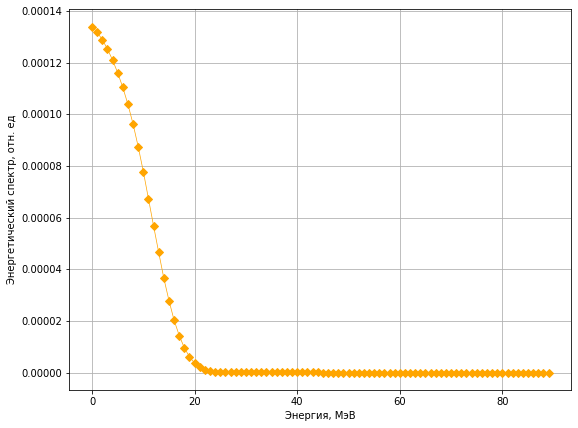

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(range(90), spectrums_signals[0][0], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

Скрипт

In [20]:
SP, DEV = [], []

for j in range(len(brems_e)):
    sp, dev = deconvolution_one_spectrum(brems_e[j], spectrums_signals[j])
    SP.append(sp)
    DEV.append(dev)
    print(f'ВЫПОЛНЕНО {j+1} из {len(brems_e)}')

(0), время: 0.0 секунд
(1), время: 5.8744 секунд
(2), время: 11.79049 секунд
(3), время: 17.65118 секунд
(4), время: 23.55005 секунд
(5), время: 29.54929 секунд
(6), время: 35.41611 секунд
(7), время: 41.28591 секунд
(8), время: 47.24895 секунд
(9), время: 53.13316 секунд
(10), время: 58.98358 секунд
(11), время: 64.88115 секунд
(12), время: 70.76528 секунд
(13), время: 76.64975 секунд
(14), время: 82.55484 секунд
(15), время: 88.46432 секунд
(16), время: 94.34711 секунд
(17), время: 100.51636 секунд
(18), время: 106.54027 секунд
(19), время: 112.82388 секунд
(20), время: 119.01492 секунд
(21), время: 124.87998 секунд
(22), время: 130.78158 секунд
(23), время: 136.67388 секунд
(24), время: 142.52605 секунд
(25), время: 148.40911 секунд
(26), время: 154.30643 секунд
(27), время: 160.29272 секунд
(28), время: 166.34877 секунд
(29), время: 172.32152 секунд
(30), время: 178.40599 секунд
(31), время: 184.51099 секунд
(32), время: 190.57165 секунд
(33), время: 196.66397 секунд
(34), время: 2

(74), время: 435.19931 секунд
(75), время: 441.11979 секунд
(76), время: 447.04673 секунд
(77), время: 452.96722 секунд
(78), время: 458.87208 секунд
(79), время: 464.76788 секунд
(80), время: 470.69217 секунд
(81), время: 476.61289 секунд
(82), время: 482.50213 секунд
(83), время: 488.39974 секунд
(84), время: 494.32287 секунд
(85), время: 500.19648 секунд
(86), время: 506.13118 секунд
(87), время: 512.08291 секунд
(88), время: 518.0034 секунд
(89), время: 523.91661 секунд
(90), время: 529.85665 секунд
(91), время: 535.77714 секунд
(92), время: 541.69202 секунд
(93), время: 547.58668 секунд
(94), время: 553.5159 секунд
(95), время: 559.40514 секунд
(96), время: 565.27876 секунд
(97), время: 571.34068 секунд
(98), время: 577.22992 секунд
(99), время: 583.13237 секунд
(100), время: 589.07445 секунд
ВЫПОЛНЕНО 3 из 50
(0), время: 0.0 секунд
(1), время: 5.83213 секунд
(2), время: 11.65888 секунд
(3), время: 17.51608 секунд
(4), время: 23.37408 секунд
(5), время: 29.23208 секунд
(6), время:

(47), время: 277.74752 секунд
(48), время: 283.66524 секунд
(49), время: 289.58423 секунд
(50), время: 295.55083 секунд
(51), время: 301.48065 секунд
(52), время: 307.4288 секунд
(53), время: 313.3502 секунд
(54), время: 319.28444 секунд
(55), время: 325.18659 секунд
(56), время: 331.05281 секунд
(57), время: 336.94055 секунд
(58), время: 342.84273 секунд
(59), время: 348.75636 секунд
(60), время: 354.62733 секунд
(61), время: 360.5759 секунд
(62), время: 366.50978 секунд
(63), время: 372.4297 секунд
(64), время: 378.31596 секунд
(65), время: 384.20635 секунд
(66), время: 390.07467 секунд
(67), время: 395.9656 секунд
(68), время: 401.82291 секунд
(69), время: 407.71071 секунд
(70), время: 413.59387 секунд
(71), время: 419.54616 секунд
(72), время: 425.44932 секунд
(73), время: 431.38561 секунд
(74), время: 437.29516 секунд
(75), время: 443.24758 секунд
(76), время: 449.16299 секунд
(77), время: 455.0339 секунд
(78), время: 460.94324 секунд
(79), время: 466.86256 секунд
(80), время: 472

(20), время: 117.24614 секунд
(21), время: 123.09694 секунд
(22), время: 128.92977 секунд
(23), время: 134.74943 секунд
(24), время: 140.61444 секунд
(25), время: 146.44813 секунд
(26), время: 152.28087 секунд
(27), время: 158.13846 секунд
(28), время: 164.00207 секунд
(29), время: 169.93359 секунд
(30), время: 175.81404 секунд
(31), время: 181.66431 секунд
(32), время: 187.56205 секунд
(33), время: 193.48098 секунд
(34), время: 199.43022 секунд
(35), время: 205.35136 секунд
(36), время: 211.21515 секунд
(37), время: 217.11423 секунд
(38), время: 222.99745 секунд
(39), время: 228.91553 секунд
(40), время: 234.79009 секунд
(41), время: 240.64877 секунд
(42), время: 246.54607 секунд
(43), время: 252.41462 секунд
(44), время: 258.31319 секунд
(45), время: 264.19109 секунд
(46), время: 270.06089 секунд
(47), время: 275.96018 секунд
(48), время: 281.88218 секунд
(49), время: 287.80217 секунд
(50), время: 293.73699 секунд
(51), время: 299.64211 секунд
(52), время: 305.51123 секунд
(53), врем

(93), время: 546.67669 секунд
(94), время: 552.52919 секунд
(95), время: 558.3972 секунд
(96), время: 564.29887 секунд
(97), время: 570.2586 секунд
(98), время: 576.14425 секунд
(99), время: 582.07488 секунд
(100), время: 587.91676 секунд
ВЫПОЛНЕНО 11 из 50
(0), время: 0.0 секунд
(1), время: 5.82074 секунд
(2), время: 11.73913 секунд
(3), время: 17.57369 секунд
(4), время: 23.39186 секунд
(5), время: 29.24042 секунд
(6), время: 35.07411 секунд
(7), время: 40.89295 секунд
(8), время: 46.75504 секунд
(9), время: 52.60559 секунд
(10), время: 58.53587 секунд
(11), время: 64.4833 секунд
(12), время: 70.62512 секунд
(13), время: 77.12706 секунд
(14), время: 83.17168 секунд
(15), время: 89.15089 секунд
(16), время: 95.03747 секунд
(17), время: 100.9522 секунд
(18), время: 106.83517 секунд
(19), время: 112.70316 секунд
(20), время: 118.57082 секунд
(21), время: 124.43645 секунд
(22), время: 130.65199 секунд
(23), время: 136.92155 секунд
(24), время: 143.18849 секунд
(25), время: 149.46995 секу

(66), время: 388.63678 секунд
(67), время: 394.49238 секунд
(68), время: 400.30088 секунд
(69), время: 406.20469 секунд
(70), время: 412.02881 секунд
(71), время: 417.89175 секунд
(72), время: 423.82434 секунд
(73), время: 429.68146 секунд
(74), время: 435.60029 секунд
(75), время: 441.51807 секунд
(76), время: 447.40519 секунд
(77), время: 453.30742 секунд
(78), время: 459.22123 секунд
(79), время: 465.10899 секунд
(80), время: 470.99912 секунд
(81), время: 476.89521 секунд
(82), время: 482.84929 секунд
(83), время: 488.79994 секунд
(84), время: 494.70231 секунд
(85), время: 500.57329 секунд
(86), время: 506.47267 секунд
(87), время: 512.37688 секунд
(88), время: 518.28175 секунд
(89), время: 524.18452 секунд
(90), время: 530.102 секунд
(91), время: 536.0372 секунд
(92), время: 542.02117 секунд
(93), время: 547.92314 секунд
(94), время: 553.76311 секунд
(95), время: 559.64802 секунд
(96), время: 565.51741 секунд
(97), время: 571.43672 секунд
(98), время: 577.30845 секунд
(99), время: 

(39), время: 228.76568 секунд
(40), время: 234.66507 секунд
(41), время: 240.58203 секунд
(42), время: 246.4484 секунд
(43), время: 252.34748 секунд
(44), время: 258.22921 секунд
(45), время: 264.14513 секунд
(46), время: 270.04363 секунд
(47), время: 275.99102 секунд
(48), время: 281.90804 секунд
(49), время: 287.82303 секунд
(50), время: 293.76473 секунд
(51), время: 299.72603 секунд
(52), время: 305.65831 секунд
(53), время: 311.55765 секунд
(54), время: 317.49189 секунд
(55), время: 323.41013 секунд
(56), время: 329.32907 секунд
(57), время: 335.22926 секунд
(58), время: 341.08162 секунд
(59), время: 346.94997 секунд
(60), время: 352.80092 секунд
(61), время: 358.71975 секунд
(62), время: 364.62176 секунд
(63), время: 370.45449 секунд
(64), время: 376.46404 секунд
(65), время: 382.35676 секунд
(66), время: 388.21872 секунд
(67), время: 394.07048 секунд
(68), время: 399.91691 секунд
(69), время: 405.76748 секунд
(70), время: 411.58657 секунд
(71), время: 417.52432 секунд
(72), время

(12), время: 70.07198 секунд
(13), время: 75.97507 секунд
(14), время: 81.78602 секунд
(15), время: 87.63942 секунд
(16), время: 93.521 секунд
(17), время: 99.38687 секунд
(18), время: 105.25381 секунд
(19), время: 111.11934 секунд
(20), время: 116.93609 секунд
(21), время: 122.75262 секунд
(22), время: 128.61532 секунд
(23), время: 134.507 секунд
(24), время: 140.37995 секунд
(25), время: 146.23242 секунд
(26), время: 152.08184 секунд
(27), время: 157.96168 секунд
(28), время: 163.81771 секунд
(29), время: 169.70888 секунд
(30), время: 175.60799 секунд
(31), время: 181.47712 секунд
(32), время: 187.32776 секунд
(33), время: 193.27605 секунд
(34), время: 199.12332 секунд
(35), время: 205.00988 секунд
(36), время: 210.89549 секунд
(37), время: 216.73037 секунд
(38), время: 222.61205 секунд
(39), время: 228.49425 секунд
(40), время: 234.34669 секунд
(41), время: 240.26002 секунд
(42), время: 246.17509 секунд
(43), время: 252.13311 секунд
(44), время: 258.07609 секунд
(45), время: 264.008

(86), время: 514.42798 секунд
(87), время: 520.54387 секунд
(88), время: 526.64887 секунд
(89), время: 532.70995 секунд
(90), время: 538.77333 секунд
(91), время: 544.73236 секунд
(92), время: 550.71747 секунд
(93), время: 556.70044 секунд
(94), время: 562.7182 секунд
(95), время: 568.81001 секунд
(96), время: 574.76786 секунд
(97), время: 580.80539 секунд
(98), время: 586.79833 секунд
(99), время: 592.78553 секунд
(100), время: 598.83966 секунд
ВЫПОЛНЕНО 22 из 50
(0), время: 0.0 секунд
(1), время: 5.91063 секунд
(2), время: 11.79956 секунд
(3), время: 17.62632 секунд
(4), время: 23.43746 секунд
(5), время: 29.24859 секунд
(6), время: 35.13771 секунд
(7), время: 41.10381 секунд
(8), время: 47.09481 секунд
(9), время: 53.13281 секунд
(10), время: 59.65821 секунд
(11), время: 66.49602 секунд
(12), время: 74.09094 секунд
(13), время: 80.44794 секунд
(14), время: 87.03433 секунд
(15), время: 93.01733 секунд
(16), время: 99.01729 секунд
(17), время: 105.05714 секунд
(18), время: 111.63455 с

(59), время: 356.87904 секунд
(60), время: 362.75914 секунд
(61), время: 368.64923 секунд
(62), время: 374.62378 секунд
(63), время: 380.73315 секунд
(64), время: 387.15509 секунд
(65), время: 394.26279 секунд
(66), время: 400.61757 секунд
(67), время: 407.32863 секунд
(68), время: 413.79534 секунд
(69), время: 420.34119 секунд
(70), время: 426.96465 секунд
(71), время: 433.1379 секунд
(72), время: 439.01242 секунд
(73), время: 444.86784 секунд
(74), время: 450.70306 секунд
(75), время: 456.55828 секунд
(76), время: 462.43144 секунд
(77), время: 468.27173 секунд
(78), время: 474.09561 секунд
(79), время: 479.96811 секунд
(80), время: 485.9018 секунд
(81), время: 491.77834 секунд
(82), время: 497.66542 секунд
(83), время: 503.53842 секунд
(84), время: 509.42477 секунд
(85), время: 515.31158 секунд
(86), время: 521.20046 секунд
(87), время: 527.05563 секунд
(88), время: 532.94391 секунд
(89), время: 538.83084 секунд
(90), время: 544.7681 секунд
(91), время: 550.68117 секунд
(92), время: 

(32), время: 192.62162 секунд
(33), время: 198.68765 секунд
(34), время: 204.75265 секунд
(35), время: 210.78632 секунд
(36), время: 216.80236 секунд
(37), время: 222.83319 секунд
(38), время: 228.78891 секунд
(39), время: 234.74465 секунд
(40), время: 240.60982 секунд
(41), время: 246.46322 секунд
(42), время: 252.34884 секунд
(43), время: 258.21942 секунд
(44), время: 264.12051 секунд
(45), время: 270.02484 секунд
(46), время: 275.9397 секунд
(47), время: 281.85465 секунд
(48), время: 287.78731 секунд
(49), время: 293.74253 секунд
(50), время: 299.74226 секунд
(51), время: 305.72998 секунд
(52), время: 311.71081 секунд
(53), время: 317.62558 секунд
(54), время: 323.59124 секунд
(55), время: 329.45717 секунд
(56), время: 335.35284 секунд
(57), время: 341.21772 секунд
(58), время: 347.0828 секунд
(59), время: 352.94796 секунд
(60), время: 358.85026 секунд
(61), время: 364.76579 секунд
(62), время: 370.63383 секунд
(63), время: 376.51684 секунд
(64), время: 382.38509 секунд
(65), время:

(4), время: 23.80391 секунд
(5), время: 29.73816 секунд
(6), время: 35.67379 секунд
(7), время: 41.62344 секунд
(8), время: 47.57406 секунд
(9), время: 53.54241 секунд
(10), время: 59.49522 секунд
(11), время: 65.44785 секунд
(12), время: 71.4141 секунд
(13), время: 77.38217 секунд
(14), время: 83.35064 секунд
(15), время: 89.30258 секунд
(16), время: 95.25684 секунд
(17), время: 101.21013 секунд
(18), время: 107.25862 секунд
(19), время: 113.2941 секунд
(20), время: 119.29782 секунд
(21), время: 125.31384 секунд
(22), время: 131.29955 секунд
(23), время: 137.31467 секунд
(24), время: 143.29941 секунд
(25), время: 149.2825 секунд
(26), время: 155.25021 секунд
(27), время: 161.25139 секунд
(28), время: 167.25144 секунд
(29), время: 173.25287 секунд
(30), время: 179.22137 секунд
(31), время: 185.18968 секунд
(32), время: 191.15723 секунд
(33), время: 197.1266 секунд
(34), время: 203.11057 секунд
(35), время: 209.07969 секунд
(36), время: 215.03035 секунд
(37), время: 221.02999 секунд
(38

(78), время: 466.70856 секунд
(79), время: 472.62041 секунд
(80), время: 478.48822 секунд
(81), время: 484.37129 секунд
(82), время: 490.27187 секунд
(83), время: 496.17315 секунд
(84), время: 502.05592 секунд
(85), время: 507.92233 секунд
(86), время: 513.82151 секунд
(87), время: 519.73736 секунд
(88), время: 525.58985 секунд
(89), время: 531.45676 секунд
(90), время: 537.37093 секунд
(91), время: 543.28729 секунд
(92), время: 549.253 секунд
(93), время: 555.17002 секунд
(94), время: 561.08666 секунд
(95), время: 566.98771 секунд
(96), время: 573.01258 секунд
(97), время: 578.93801 секунд
(98), время: 584.87152 секунд
(99), время: 590.76943 секунд
(100), время: 596.63467 секунд
ВЫПОЛНЕНО 33 из 50
(0), время: 0.0 секунд
(1), время: 5.8179 секунд
(2), время: 11.65267 секунд
(3), время: 17.4707 секунд
(4), время: 23.3219 секунд
(5), время: 29.15516 секунд
(6), время: 35.00443 секунд
(7), время: 40.87226 секунд
(8), время: 46.7413 секунд
(9), время: 52.62481 секунд
(10), время: 58.54363 

(51), время: 304.14843 секунд
(52), время: 310.39746 секунд
(53), время: 316.64599 секунд
(54), время: 322.85981 секунд
(55), время: 329.05835 секунд
(56), время: 335.32138 секунд
(57), время: 341.83614 секунд
(58), время: 348.2846 секунд
(59), время: 354.68236 секунд
(60), время: 360.99734 секунд
(61), время: 367.2989 секунд
(62), время: 373.43427 секунд
(63), время: 379.69985 секунд
(64), время: 385.77017 секунд
(65), время: 391.78681 секунд
(66), время: 397.82071 секунд
(67), время: 403.83694 секунд
(68), время: 409.87295 секунд
(69), время: 415.8738 секунд
(70), время: 421.88986 секунд
(71), время: 427.89355 секунд
(72), время: 433.87875 секунд
(73), время: 439.88056 секунд
(74), время: 445.86664 секунд
(75), время: 451.88396 секунд
(76), время: 457.98539 секунд
(77), время: 464.03808 секунд
(78), время: 470.08963 секунд
(79), время: 476.17371 секунд
(80), время: 482.25703 секунд
(81), время: 488.34168 секунд
(82), время: 494.4423 секунд
(83), время: 500.54342 секунд
(84), время: 5

(24), время: 140.80197 секунд
(25), время: 146.65619 секунд
(26), время: 152.52547 секунд
(27), время: 158.39234 секунд
(28), время: 164.24346 секунд
(29), время: 170.1037 секунд
(30), время: 175.97619 секунд
(31), время: 181.79607 секунд
(32), время: 187.6609 секунд
(33), время: 193.49703 секунд
(34), время: 199.36631 секунд
(35), время: 205.28557 секунд
(36), время: 211.11433 секунд
(37), время: 216.96501 секунд
(38), время: 222.83002 секунд
(39), время: 228.68137 секунд
(40), время: 234.54645 секунд
(41), время: 240.39775 секунд
(42), время: 246.29884 секунд
(43), время: 252.19971 секунд
(44), время: 258.08736 секунд
(45), время: 264.0374 секунд
(46), время: 269.97225 секунд
(47), время: 275.95489 секунд
(48), время: 282.08046 секунд
(49), время: 288.05761 секунд
(50), время: 294.05558 секунд
(51), время: 300.05518 секунд
(52), время: 306.03791 секунд
(53), время: 312.00458 секунд
(54), время: 318.0864 секунд
(55), время: 324.11349 секунд
(56), время: 330.12336 секунд
(57), время: 3

(97), время: 577.36144 секунд
(98), время: 583.39643 секунд
(99), время: 589.41132 секунд
(100), время: 595.42653 секунд
ВЫПОЛНЕНО 41 из 50
(0), время: 0.0 секунд
(1), время: 6.00143 секунд
(2), время: 12.00022 секунд
(3), время: 17.98599 секунд
(4), время: 23.97025 секунд
(5), время: 29.95407 секунд
(6), время: 35.92348 секунд
(7), время: 41.89195 секунд
(8), время: 47.89334 секунд
(9), время: 53.91139 секунд
(10), время: 59.91191 секунд
(11), время: 65.93037 секунд
(12), время: 71.92999 секунд
(13), время: 77.98155 секунд
(14), время: 84.04945 секунд
(15), время: 90.08429 секунд
(16), время: 96.13645 секунд
(17), время: 102.18873 секунд
(18), время: 108.22355 секунд
(19), время: 114.2759 секунд
(20), время: 120.29513 секунд
(21), время: 126.34662 секунд
(22), время: 132.38257 секунд
(23), время: 138.38326 секунд
(24), время: 144.36616 секунд
(25), время: 150.27038 секунд
(26), время: 156.13727 секунд
(27), время: 162.0042 секунд
(28), время: 167.83802 секунд
(29), время: 173.70492 се

(70), время: 416.32546 секунд
(71), время: 422.17381 секунд
(72), время: 428.06266 секунд
(73), время: 433.96424 секунд
(74), время: 439.80898 секунд
(75), время: 445.64211 секунд
(76), время: 451.49088 секунд
(77), время: 457.32773 секунд
(78), время: 463.19203 секунд
(79), время: 469.09065 секунд
(80), время: 474.94514 секунд
(81), время: 480.81018 секунд
(82), время: 486.6766 секунд
(83), время: 492.52826 секунд
(84), время: 498.42867 секунд
(85), время: 504.34585 секунд
(86), время: 510.26247 секунд
(87), время: 516.195 секунд
(88), время: 522.19207 секунд
(89), время: 528.12639 секунд
(90), время: 534.10672 секунд
(91), время: 540.10553 секунд
(92), время: 546.13986 секунд
(93), время: 552.22971 секунд
(94), время: 558.22314 секунд
(95), время: 564.20715 секунд
(96), время: 570.23835 секунд
(97), время: 576.2547 секунд
(98), время: 582.26829 секунд
(99), время: 588.28616 секунд
(100), время: 594.26796 секунд
ВЫПОЛНЕНО 44 из 50
(0), время: 0.0 секунд
(1), время: 5.59159 секунд
(2),

(43), время: 256.74606 секунд
(44), время: 262.79681 секунд
(45), время: 268.88155 секунд
(46), время: 274.93356 секунд
(47), время: 281.01554 секунд
(48), время: 287.099 секунд
(49), время: 293.16729 секунд
(50), время: 299.25056 секунд
(51), время: 305.36775 секунд
(52), время: 311.48217 секунд
(53), время: 317.51692 секунд
(54), время: 323.4829 секунд
(55), время: 329.3659 секунд
(56), время: 335.23319 секунд
(57), время: 341.06445 секунд
(58), время: 346.94657 секунд
(59), время: 352.779 секунд
(60), время: 358.65916 секунд
(61), время: 364.49243 секунд
(62), время: 370.38924 секунд
(63), время: 376.28612 секунд
(64), время: 382.16907 секунд
(65), время: 388.01724 секунд
(66), время: 393.86673 секунд
(67), время: 399.68327 секунд
(68), время: 405.5166 секунд
(69), время: 411.3675 секунд
(70), время: 417.18529 секунд
(71), время: 423.08869 секунд
(72), время: 428.99346 секунд
(73), время: 434.83647 секунд
(74), время: 440.68631 секунд
(75), время: 446.5373 секунд
(76), время: 452.41

(16), время: 93.28248 секунд
(17), время: 99.11462 секунд
(18), время: 104.96426 секунд
(19), время: 110.81515 секунд
(20), время: 116.66491 секунд
(21), время: 122.53274 секунд
(22), время: 128.41427 секунд
(23), время: 134.3135 секунд
(24), время: 140.22933 секунд
(25), время: 146.11564 секунд
(26), время: 151.99982 секунд
(27), время: 157.91568 секунд
(28), время: 163.84781 секунд
(29), время: 169.73522 секунд
(30), время: 175.66738 секунд
(31), время: 181.61631 секунд
(32), время: 187.6034 секунд
(33), время: 193.55937 секунд
(34), время: 199.53009 секунд
(35), время: 205.52899 секунд
(36), время: 211.52667 секунд
(37), время: 217.46219 секунд
(38), время: 223.44401 секунд
(39), время: 229.39457 секунд
(40), время: 235.33039 секунд
(41), время: 241.28203 секунд
(42), время: 247.24846 секунд
(43), время: 253.24681 секунд
(44), время: 259.3572 секунд
(45), время: 265.36457 секунд
(46), время: 271.34918 секунд
(47), время: 277.36493 секунд
(48), время: 283.39751 секунд
(49), время: 28

Сохранение данных

In [21]:
np.save(f'K_{m}_SP.npy', SP)
np.save(f'K_{m}_DEV.npy', DEV)

Загрузка данных

Построение

In [22]:
from mpl_toolkits.mplot3d import Axes3D

In [23]:
D = np.array(DEV)
X,Y = np.meshgrid(edge_max_values, beams_energyes)
X, Ylog = np.meshgrid(edge_max_values, np.log10(beams_energyes))
Xlog, Ylog = np.meshgrid(np.log10(edge_max_values), np.log10(beams_energyes))

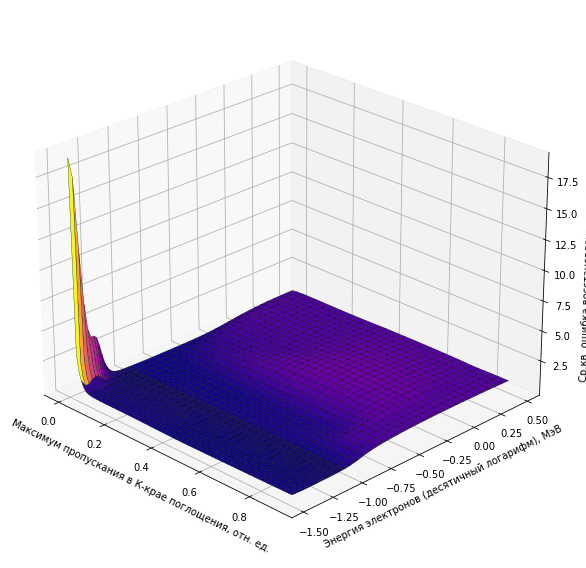

In [24]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': '3d'})
ax.plot_surface(X, Ylog, D, cmap='plasma', linewidth=0.3, edgecolors='k', shade=True)

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов (десятичный логарифм), МэВ')
ax.set_zlabel('Ср.кв. ошибка восстановления, отн. ед.')
fig.tight_layout()

# угол зрения (линейный)
# ax.view_init(elev=20, azim=-135)

# угол зрения (логарифм)
ax.view_init(elev=25, azim=-45)

# fig.savefig('К_фильтры_3D.jpg', bbox_inches='tight')

Контурная карта

In [25]:
linspace4 = np.geomspace(1e-2, 0.3, 20)
linspace5 = np.linspace(0.31, 1.4, 10)

In [26]:
c_map_levels = []
c_map_levels.extend(linspace4)
c_map_levels.extend(linspace5)

Text(0, 0.5, 'Энергия электронов, МэВ')

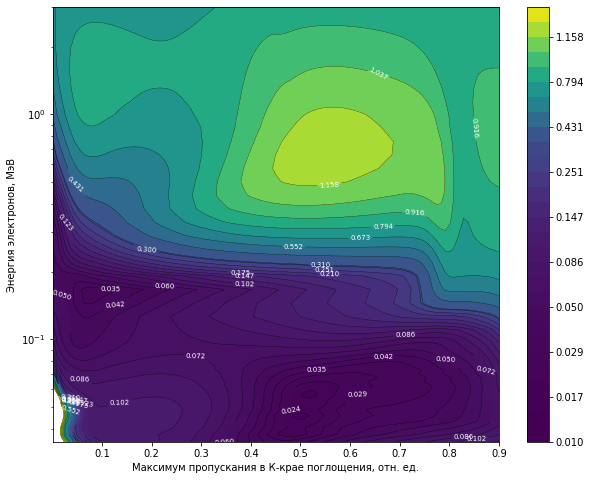

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

c_map = ax.contourf(X, Y, D, levels=c_map_levels)
borders = ax.contour(X, Y, D, colors='k', levels=c_map_levels, linewidths=0.3)
ax.clabel(borders, fontsize=7, colors='w')
fig.colorbar(c_map)
ax.set_yscale('log')

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов, МэВ')

# fig.savefig('К_фильтры_контурная_карта.jpg', bbox_inches='tight')

Зависимость минимальной ошибки восстановления от граничной энерии спектра

In [28]:
minimal_deviations = []

for i,val in enumerate(beams_energyes):
    min_value = min(DEV[i])
    minimal_deviations.append(min_value)

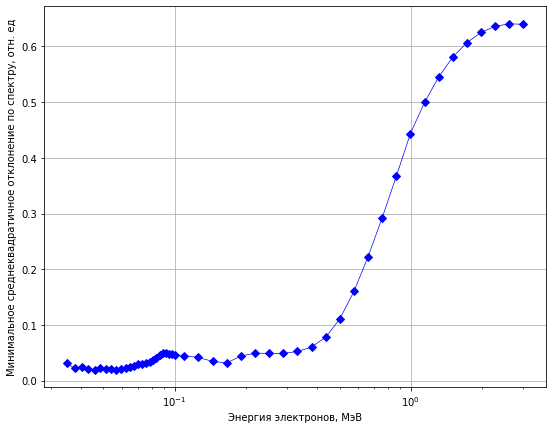

In [32]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(beams_energyes, minimal_deviations, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия электронов, МэВ', fontsize=10)
ax.set_ylabel('Минимальное среднеквадратичное отклонение по спектру, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True)

# ax.set_xlim(3e-2, 0.14)
# ax.set_ylim(0, 0.150)

# fig.savefig('К_фильтры_минимум_ошибки_восстановления_от_энергии_электронов.jpg', bbox_inches='tight')

In [30]:
np.save(f'K_{m}_MIN.npy', minimal_deviations)